In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


%config InlineBackend.figure_format = 'retina'
#plt.rcParams['figure.figsize'] = 8, 5
#plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'

In [40]:
data = pd.read_csv("powerconsumption.csv")
data['Datetime'] = pd.to_datetime(data['Datetime'])

df = data[['Datetime', 'PowerConsumption_Zone1']].copy()

df = df.set_index('Datetime')
df = df.resample('h').mean()

df = df.rename(columns={"PowerConsumption_Zone1": "count"})
df = df.reset_index(drop=True)

y = df["count"].values
y

array([29197.97468333, 24657.21519   , 22083.03797333, ...,
       35358.174905  , 33993.40938   , 30107.98478833])

In [41]:
from pmdarima.model_selection import train_test_split

day_length = 24

#day_num = 60
day_num = 120
test_days = 8
train_days = day_num - test_days

y = y[:day_length * day_num]

y_train, y_test = train_test_split(
    y,
    train_size=train_days * day_length
)

In [42]:
def split_inputs_and_targets(mulvar_series, ahead=24):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:]

In [43]:
import tensorflow as tf
from tensorflow.keras import utils

batch_size = 365

ahead_train_ds = utils.timeseries_dataset_from_array(
    y_train,
    targets=None,
    sequence_length=24 + 24,
    batch_size=batch_size,
    sequence_stride=24
    #shuffle=True,
    #seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = utils.timeseries_dataset_from_array(
    y_test,
    targets=None,
    sequence_length=24 + 24,
    batch_size=batch_size,
    sequence_stride=24
).map(split_inputs_and_targets)

ahead_evaluate_ds = utils.timeseries_dataset_from_array(
    y,
    targets=None,
    sequence_length=24 + 24,
    batch_size=batch_size,
    sequence_stride=24
).map(split_inputs_and_targets)

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers

model = Sequential([
    layers.LSTM(128, activation='relu', kernel_initializer="he_normal", input_shape=[None, 1]),
    layers.Dense(24)
])

early_stopping_cb = callbacks.EarlyStopping(
    monitor="val_mape", patience=100, restore_best_weights=True, verbose=1)

opt = optimizers.Adam(learning_rate=0.01, clipnorm=0.001)


model.compile(
    loss='mse',
    optimizer=opt, 
    metrics=["mape"]
)

history = model.fit(ahead_train_ds, 
                          validation_data=ahead_evaluate_ds, epochs=2000,
                    callbacks=[early_stopping_cb])

Epoch 1/2000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 26900301824.0000 - mape: 441.3744 - val_loss: 29085761536.0000 - val_mape: 469.3112
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 29096361984.0000 - mape: 469.8542 - val_loss: 6265783808.0000 - val_mape: 208.5311
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 6361607680.0000 - mape: 209.2868 - val_loss: 5289507840.0000 - val_mape: 189.2390
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 5262902272.0000 - mape: 189.3109 - val_loss: 2072667392.0000 - val_mape: 116.2551
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 2078196992.0000 - mape: 116.4871 - val_loss: 4480392192.0000 - val_mape: 179.4548
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 4382028800.0000 - mape: 177.3826 - val_loss: 3519998976.0000 - val_mape: 156.2330
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 3525733120.0000 - mape: 156.0499 - val_loss: 1591035008.0000 - val_mape: 102.3586
Epoch 8/2000
1/1 ━━

In [44]:
model.load_weights("LSTM_MAPE_2_68.weights.h5")

In [45]:
model.evaluate(ahead_evaluate_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 2255049.7500 - mape: 3.2796


[2255049.75, 3.2796194553375244]

In [46]:
y_pred = model.predict(ahead_evaluate_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


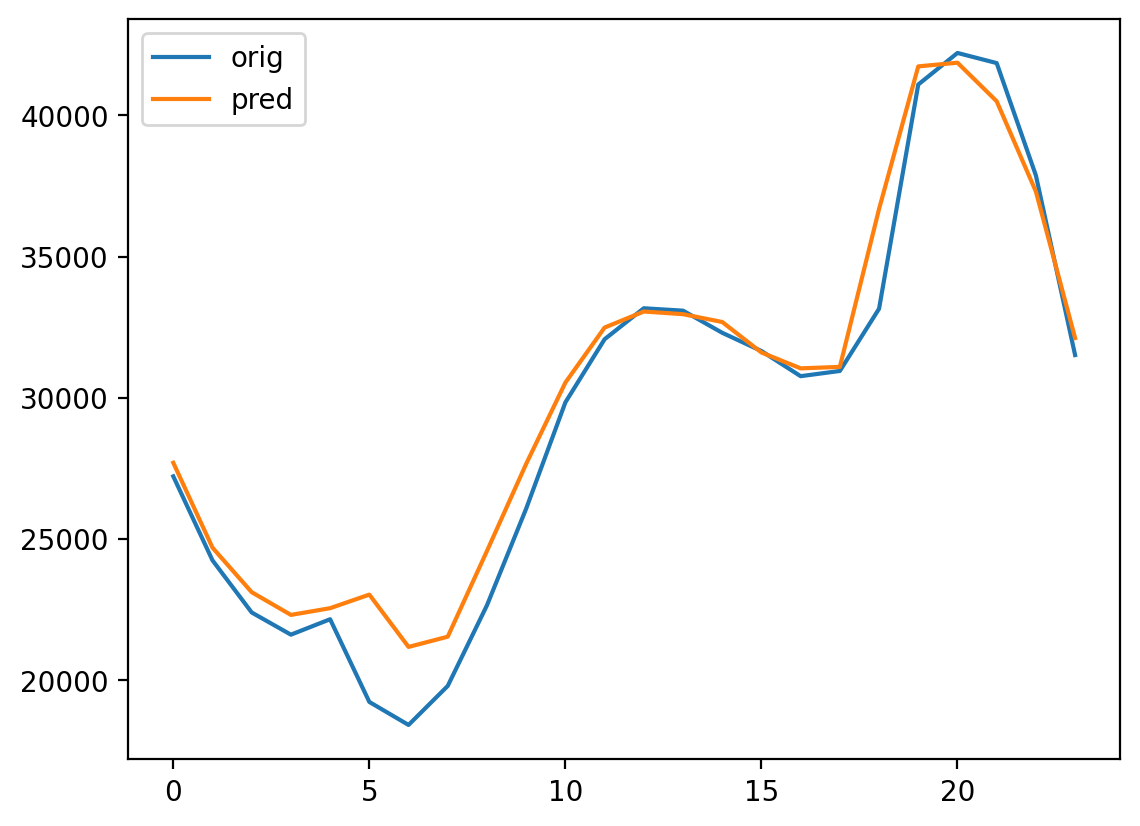

In [47]:
day = 0
plt.plot(y_test[day * 24:(day + 1) * 24], label="orig")
plt.plot(y_pred[day_num - 1 - test_days + day], label="pred")
plt.legend()

In [48]:
model.evaluate(ahead_valid_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1248690.6250 - mape: 2.8173


[1248690.625, 2.8173229694366455]

In [49]:
y_pred = model.predict(ahead_valid_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [50]:
y_pred_pred = y_pred.flatten()

In [51]:
fig = plt.figure()
size = fig.get_size_inches()
size

array([6.4, 4.8])

<Figure size 640x480 with 0 Axes>

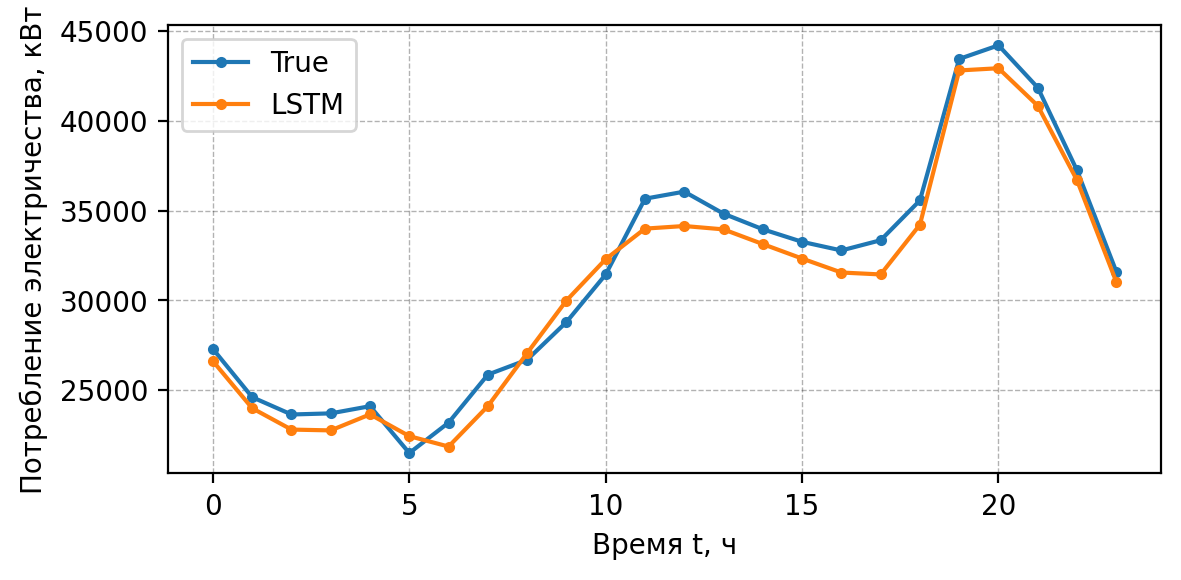

In [52]:
day = 0

plt.subplots(figsize=(6, 3))

plt.plot(y_test[24 * (day + 1):24*(day + 2)], label="True", marker=".")
plt.plot(y_pred[day], label="LSTM", marker=".")
plt.grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.3)
plt.legend()

plt.ylabel("Потребление электричества, кВт")
plt.xlabel("Время t, ч")
plt.tight_layout()
plt.savefig("LSTM_predict.pdf")

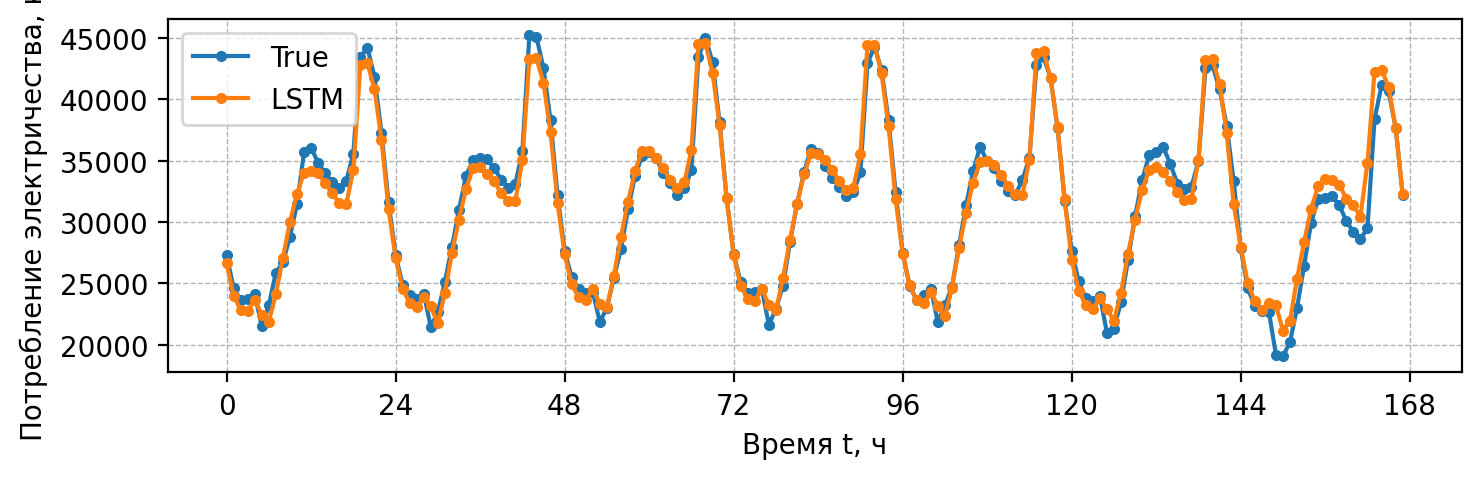

In [53]:
plt.subplots(figsize=(7.5, 2.5))
#fig.suptitle('Horizontally stacked subplots')


day = 0
plt.plot(y_test[24:], label="True", marker=".")
plt.plot(y_pred_pred, label="LSTM", marker=".")
plt.grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.3)

plt.xticks(np.arange(0, 175, 24))

plt.legend()

plt.ylabel("Потребление электричества, кВт")
plt.xlabel("Время t, ч")

plt.tight_layout()
plt.savefig("LSTM_week_predict.pdf")

Test MAE = 831.8810901997

Test MAPE = 0.0281732328

r^2 on test data : 0.970283
Explained_variance on test data : 0.970285



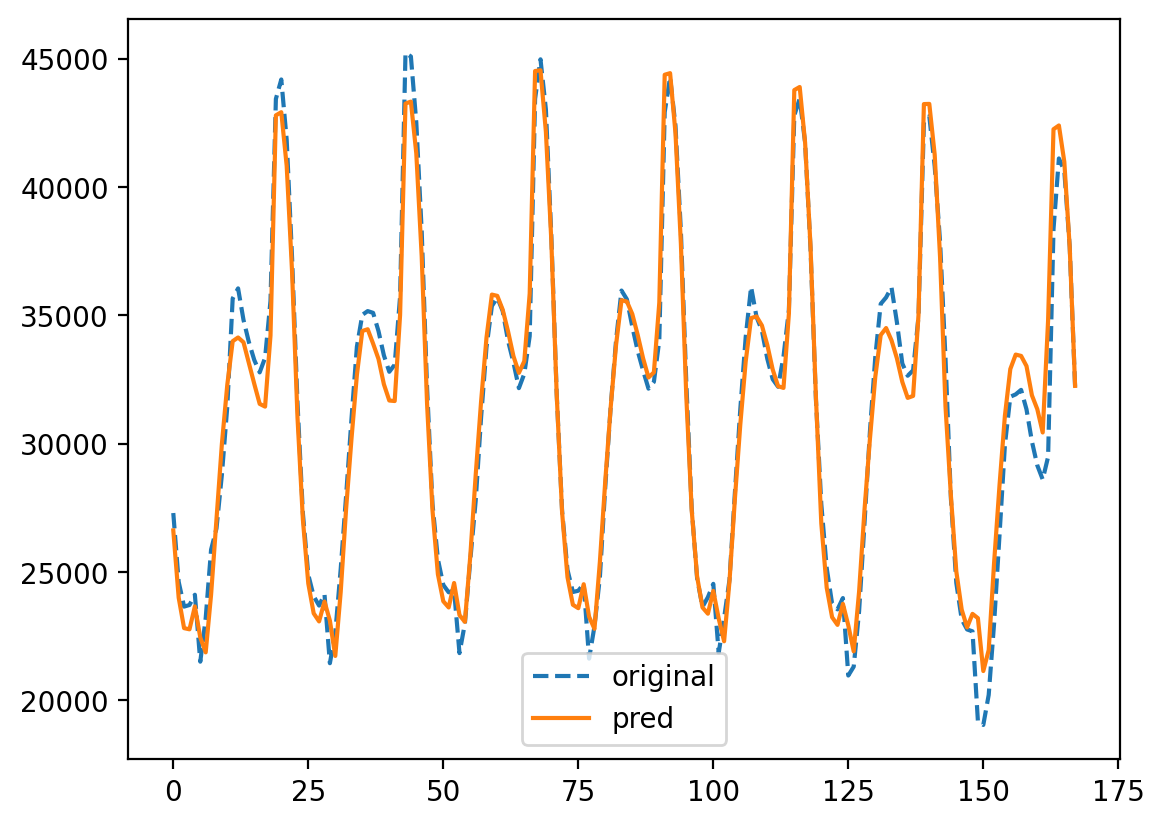

In [55]:
from local_utils import another_show_statistics

# Test dataset results
another_show_statistics(y_test[24:], y_pred_pred)

Далее идет проверка остатков

------ Check for zero-mean ------
T statistic: 0.11347387243848982
P-value: 0.9097911740058353
Fail to reject the null hypothesis; there is no significant difference between the sample mean and the hypothesized population mean.
---------------------------------

------ Check for stationarity ------
Augmneted Dickey-Fuller Statistic: -2.580301
p-value: 0.097137
critical values at different levels:
	1%: -3.473830
	5%: -2.880623
	10%: -2.576945

If p-value <= significance level (default: 0.05) or ADF statistic < critical value - there is stationarity


Results of KPSS Test:
Test Statistic           0.8341
p-value                  0.0100
Lags Used                7.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical Value (1%)      0.7390
dtype: float64

If p-val < 0.05,then series is non-stationary
------------------------------------

------ Check for autocorrelation ------
Durbin-Watson: 0.6270270196256642

The Ljung-Box test:
   

/var/folders/bc/6rxysh0n6rg3nxwj2xwz6gsr0000gn/T/ipykernel_21567/3129967033.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


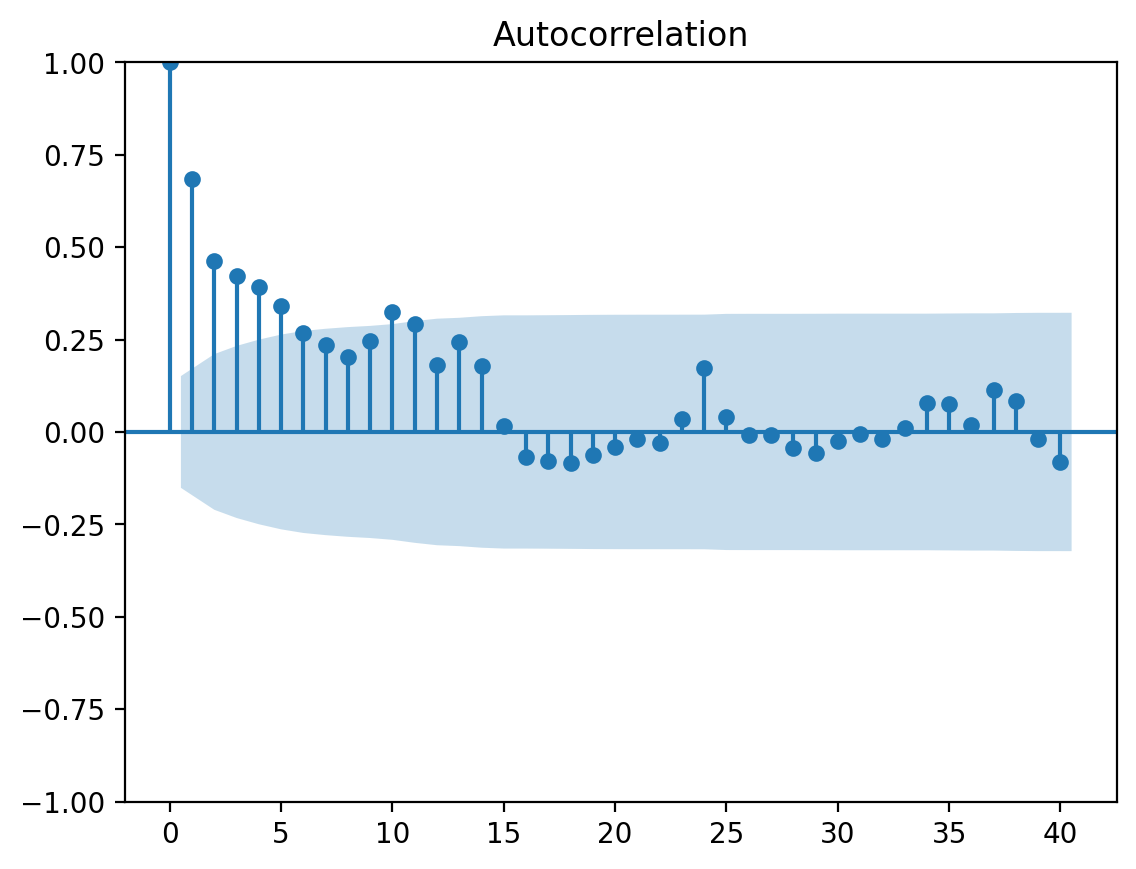

In [56]:
def adf_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    
    res = adfuller(timeseries, autolag="AIC")
    
    print('Augmneted Dickey-Fuller Statistic: %f' % res[0])
    print('p-value: %f' % res[1])
    
    print('critical values at different levels:')
    for k, v in res[4].items():
        print('\t%s: %.6f' % (k, v))
    
    print()
    print("If p-value <= significance level (default: 0.05) or ADF statistic < critical value - there is stationarity")

def kpss_test(timeseries):
    from statsmodels.tsa.stattools import kpss
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output.round(5))
    print()
    print("If p-val < 0.05," \
    "then series is non-stationary")

def check_residuals_for_autocorr(resid):
    from statsmodels.stats.stattools import durbin_watson
    from statsmodels.stats.diagnostic import acorr_ljungbox
    
    dw = durbin_watson(resid)
    print(f"Durbin-Watson: {dw}")
    
    print()
    
    lb = acorr_ljungbox(resid, boxpierce=True, lags=48)
    print("The Ljung-Box test:")
    print(lb)
    
    print()
    print("So, if no autocorrelation in res, " \
    "p-val > 0.05 and Durbin-Watson = 2")

resid = y_test[24:] - y_pred_pred

print("------ Check for zero-mean ------")
from scipy import stats

mu = 0.0

t_stat, p_value = stats.ttest_1samp(resid, mu)
print("T statistic:", t_stat)
print("P-value:", p_value)

# Setting significance level
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis;" \
    " there is a significant difference between " \
    "the sample mean and the hypothesized population mean.")
else:
    print("Fail to reject the null hypothesis; " \
    "there is no significant difference between " \
    "the sample mean and the hypothesized population mean.")

print("---------------------------------")
print()
print("------ Check for stationarity ------")
adf_test(resid)

print()
print()

kpss_test(resid)

print("------------------------------------")
print()
print("------ Check for autocorrelation ------")
check_residuals_for_autocorr(resid)
print("---------------------------------------")

import statsmodels.api as sm

sm.graphics.tsa.plot_acf(resid, lags=40)
plt.show()

In [57]:
model.evaluate(ahead_train_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 2320267.0000 - mape: 3.3020


[2320267.0, 3.3019678592681885]

In [62]:
y_pred = model.predict(ahead_train_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


In [63]:
y_pred_pred = y_pred.flatten()

Test MAE = 997.2108310769

Test MAPE = 0.0330196791

r^2 on test data : 0.950479
Explained_variance on test data : 0.951045



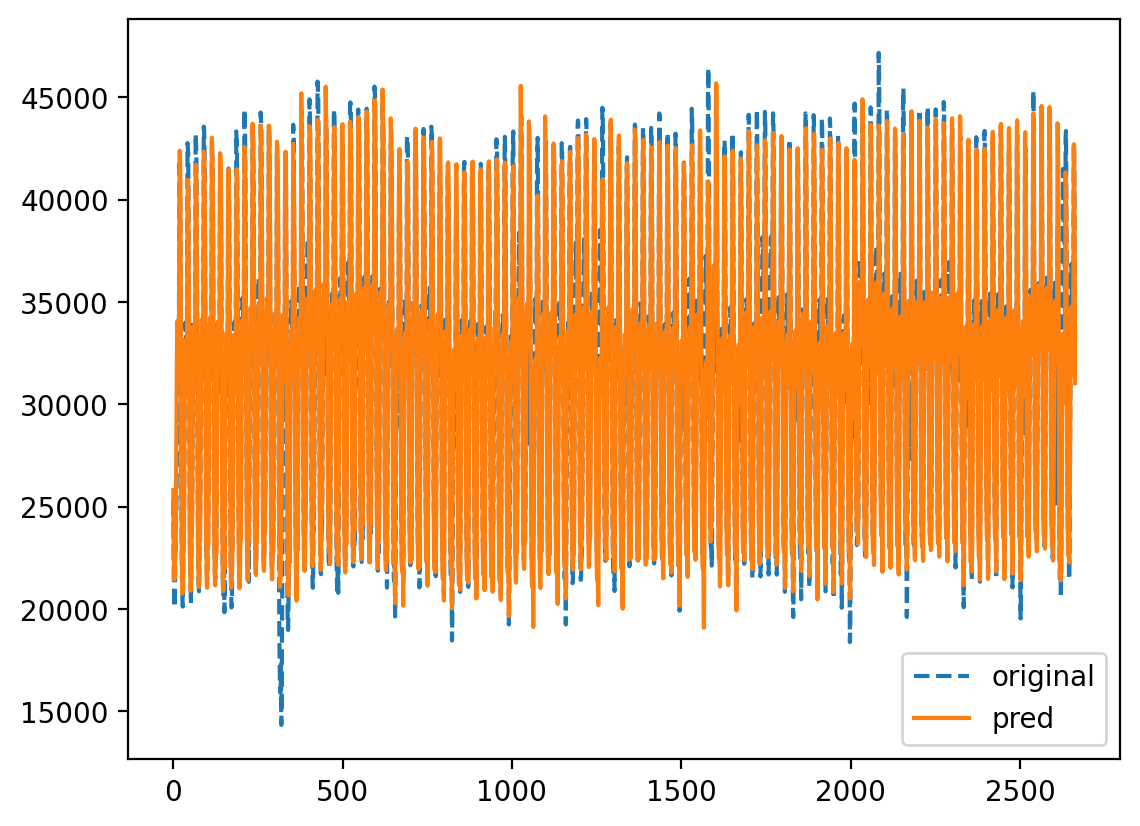

In [64]:
another_show_statistics(y_train[24:], y_pred_pred)

------ Check for zero-mean ------
T statistic: 5.546783261134962
P-value: 3.196053519197077e-08
Reject the null hypothesis; there is a significant difference between the sample mean and the hypothesized population mean.
---------------------------------

------ Check for stationarity ------
Augmneted Dickey-Fuller Statistic: -10.171248
p-value: 0.000000
critical values at different levels:
	1%: -3.432831
	5%: -2.862636
	10%: -2.567354

If p-value <= significance level (default: 0.05) or ADF statistic < critical value - there is stationarity


Results of KPSS Test:
Test Statistic            0.13105
p-value                   0.10000
Lags Used                27.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64

If p-val < 0.05,then series is non-stationary
------------------------------------

------ Check for autocorrelation ------
Durbin-Watson: 0.2936099026990151

The Ljung-Box te

/var/folders/bc/6rxysh0n6rg3nxwj2xwz6gsr0000gn/T/ipykernel_21567/166102388.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


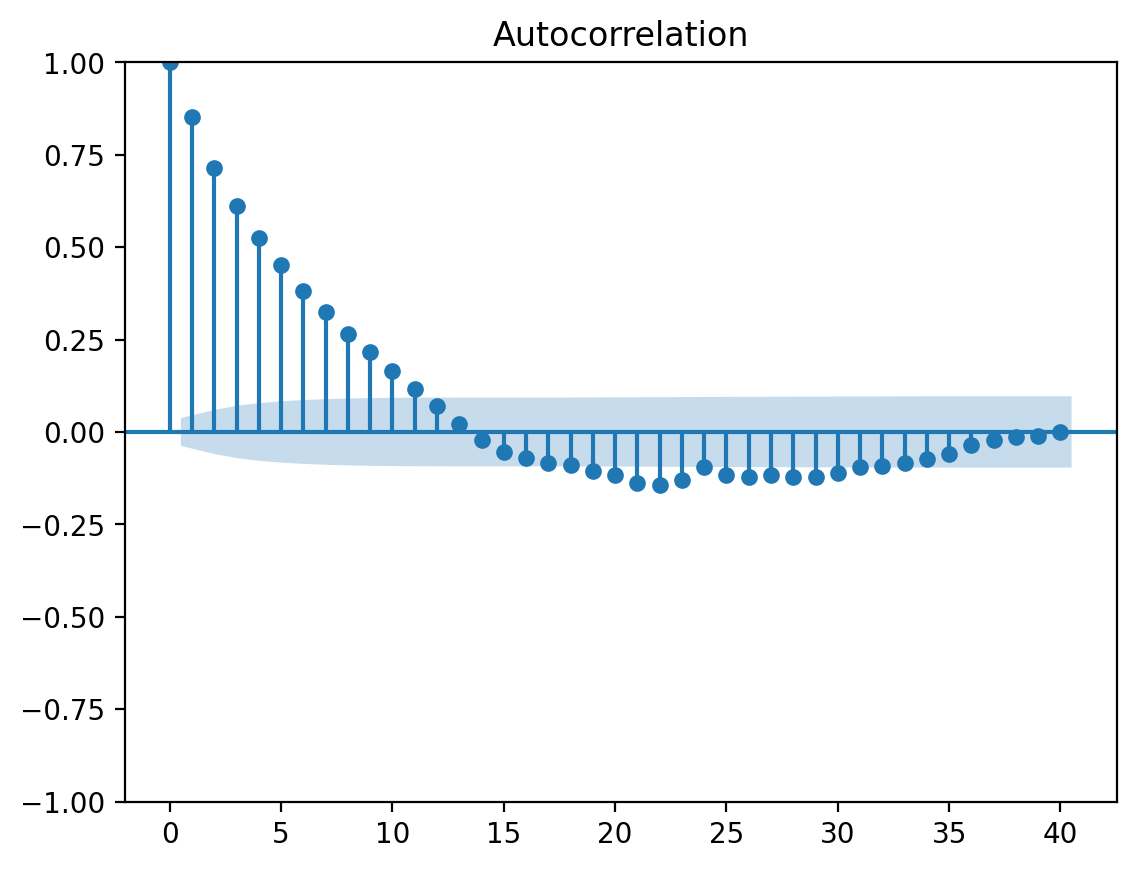

In [65]:
def adf_test(timeseries):
    from statsmodels.tsa.stattools import adfuller
    
    res = adfuller(timeseries, autolag="AIC")
    
    print('Augmneted Dickey-Fuller Statistic: %f' % res[0])
    print('p-value: %f' % res[1])
    
    print('critical values at different levels:')
    for k, v in res[4].items():
        print('\t%s: %.6f' % (k, v))
    
    print()
    print("If p-value <= significance level (default: 0.05) or ADF statistic < critical value - there is stationarity")

def kpss_test(timeseries):
    from statsmodels.tsa.stattools import kpss
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output.round(5))
    print()
    print("If p-val < 0.05," \
    "then series is non-stationary")

def check_residuals_for_autocorr(resid):
    from statsmodels.stats.stattools import durbin_watson
    from statsmodels.stats.diagnostic import acorr_ljungbox
    
    dw = durbin_watson(resid)
    print(f"Durbin-Watson: {dw}")
    
    print()
    
    lb = acorr_ljungbox(resid, boxpierce=True, lags=48)
    print("The Ljung-Box test:")
    print(lb)
    
    print()
    print("So, if no autocorrelation in res, " \
    "p-val > 0.05 and Durbin-Watson = 2")

resid = y_train[24:] - y_pred_pred

print("------ Check for zero-mean ------")
from scipy import stats

mu = 0.0

t_stat, p_value = stats.ttest_1samp(resid, mu)
print("T statistic:", t_stat)
print("P-value:", p_value)

# Setting significance level
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis;" \
    " there is a significant difference between " \
    "the sample mean and the hypothesized population mean.")
else:
    print("Fail to reject the null hypothesis; " \
    "there is no significant difference between " \
    "the sample mean and the hypothesized population mean.")

print("---------------------------------")
print()
print("------ Check for stationarity ------")
adf_test(resid)

print()
print()

kpss_test(resid)

print("------------------------------------")
print()
print("------ Check for autocorrelation ------")
check_residuals_for_autocorr(resid)
print("---------------------------------------")

import statsmodels.api as sm

sm.graphics.tsa.plot_acf(resid, lags=40)
plt.show()

Продолжение обучение (непрерывное обучение нейросети)

Тут мы добавили еще 30 дней

In [31]:
y = df["count"].values

day_length = 24

#day_num = 60
day_num = 130
test_days = 6
train_days = day_num - test_days

y = y[:day_length * day_num]

y_train, y_test = train_test_split(
    y,
    train_size=train_days * day_length
)

In [32]:
ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    y_train,
    targets=None,
    sequence_length=24 + 24,
    batch_size=batch_size,
    sequence_stride=24
    #shuffle=True,
    #seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    y_test,
    targets=None,
    sequence_length=24 + 24,
    batch_size=batch_size,
    sequence_stride=24
).map(split_inputs_and_targets)

ahead_evaluate_ds = tf.keras.utils.timeseries_dataset_from_array(
    y,
    targets=None,
    sequence_length=24 + 24,
    batch_size=batch_size,
    sequence_stride=24
).map(split_inputs_and_targets)

In [18]:
history = model.fit(ahead_train_ds, 
                          validation_data=ahead_evaluate_ds, epochs=2000,
                    callbacks=[early_stopping_cb])

Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 1523.0398 - mape: 5.0224 - val_loss: 1586.6079 - val_mape: 5.2450
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 1583.9130 - mape: 5.2333 - val_loss: 2472.8789 - val_mape: 8.2163
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 2457.3735 - mape: 8.1733 - val_loss: 1604.0525 - val_mape: 5.3183
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 1597.0612 - mape: 5.2916 - val_loss: 1933.3225 - val_mape: 6.1857
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 1933.0458 - mape: 6.1767 - val_loss: 1720.3634 - val_mape: 5.6873
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 1726.4222 - mape: 5.7008 - val_loss: 1890.2316 - val_mape: 6.4154
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 1892.0388 - mape: 6.4223 - val_loss: 1883.0812 - val_mape: 6.3032
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1878.7201 - mape: 6.2915 - val_loss: 1726.3502 - val_mape: